In [1]:
# Simulating dynamics of Argon atoms
# Starting with outlining general kinematics of particles

Week 1:
Play around with this system. Start by simulating the time evolution of a few particles in a periodic box, 
add the forces due to the Lennard-Jones potential. Check how the total energy of your system evolves over time.
It's easier to start with a 2D system, but plan to switch to 3D at a later stage.
Week 2:
Derive the expression of the kinetic energy in dimensionless units
Write a molecular dynamics code that uses dimensionless units and simulate a few atoms. 
Plot both kinetic, potential and total energy.
Boundary condition, minimal image convention

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u

In [3]:
def norm(r, axis=0):
    ''' Calculate the magnitude/norm of a vector r'''
    return np.sqrt(np.sum(r**2.0, axis))

# Acceleration = Force
def acceleration(r):
    '''Force between partices r apart
    r is magnitude (dimensionless)'''
    nablaU = dUdr(norm(r)) * r / norm(r)
    return -nablaU

def apply_boundary_conditions(x):
    '''Apply boundary conditions for a box of size L x L x L to position x'''
    for d in range(3):
        if (x[d] < 0.0):
            x[d] = L - x[d]
        elif (x[d] > L):
            x[d] = x[d] - L
    return x

# velocity at time t
def current_velocity(x_next, x_prev):
    '''Current velocity of a particle
    next position x_next from function at time t+h
    previous position at time t-h'''
    v = (x_next - x_prev)/(2.0*h)
    return v

# position at t+h
def next_position(x, v, force):
    '''The next position value
    current position x at time t
    current velocity v
    force from acceleration, at time t
    Dimensionless units'''
    x_next = x + h * v + (h**2.0 / 2.0 * force)
    return apply_boundary_conditions(x_next)

# velocity at time t+h
def next_velocity(v, force, force_next):
    '''Finding the next velocity value
    current velocity time t
    current force time t
    next force time t+h
    Dimensionless units'''
    v_next = v + h / 2.0 * (force + force_next)
    return v_next

# Potential Energy
def LJP(r):
    '''Lennard-Jones potential formula
    Describes the potential of the system given a distance between two particles
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return 4*(1/(r**12.) - 1/(r**6.))

# Kinetic Energy
def KE(v):
    '''Kinetic energy from velocity vector'''
    return 0.5 * v**2.0

def dUdr(r):
    ''' Derivative of LJP WRT r
    in dimensionless units, no sigma or epsilon
    function of magnitude distance r'''
    return -48./(r**13.) + 24/(r**7.)

def get_r(state, t, particle):
    '''Determine the closest particle for a given particle at a given time (t) and
       return the distance between these two particles'''
    xi = state[particle, t, :3]
    xj = np.delete(state[:, t, :3], particle, axis=0) # exclude the particle itself
    #closest_part = (norm((xi - xj + L/2) % L - L/2, axis = 1)).argmin()
    closest_part = (norm(xi - xj, axis = 1)).argmin()
    closest_part_pos = xj[closest_part]
    return xi - closest_part_pos

In [4]:
# Parameters given in dimensionless units of sigma
#  Perhaps convert between units later
# Variables
# Argon
# epsilon = const.k_B * 119.8*u.K
# sigma = 3.405*u.AA
# mass = 39.948*u.u

In [5]:
# The force at x is the negative gradient of the potential at x
# The gradient of the potential is the derivative of the potential WRT r times x/r
# where r is the magnitude of the distance and x is a vector

# Initial conditions
h = 0.05                         # time step
num_time = 50                    # number of time steps
num_part_per_dim = 2             # number of particles in each direction
num_part = num_part_per_dim**2   # total number of particles
L = 4.0                          # size of box

# calculate the initial coordinates by seperating all particles at a fixed distance
start = 0.5 / num_part_per_dim
inital_coords = np.linspace(start, 1 - start, num_part_per_dim) * L

In [6]:
# state consists of 6 degrees of freedom: 3 position coordinates, 3 velocities
state = np.zeros((num_part, num_time, 6))

# store the kinetic and potential energy of 2 particles in 3 dimensions for num_time timesteps
E_kin = np.zeros((num_part, num_time, 3))
E_pot = np.zeros((num_part, num_time))
E_tot = np.zeros((num_part, num_time))

# place the particles on a rectangular grid
state[:, 0, 0] = np.tile(inital_coords, num_part_per_dim)
state[:, 0, 1] = np.repeat(inital_coords, num_part_per_dim)

# place one of the particles in the center
state[0, :, :3] = np.tile(np.asarray([0.5, 0.5, 0.0]) * L, num_time).reshape((num_time,3))

# store initial kinetic, potential and total energy of each particle and the system
for i in range(num_part):
    E_kin[i, 0, :] = KE(state[i, 0, 3:])
    E_pot[i, 0] = 0
    E_tot[i, 0] += E_pot[i, 0] + norm(E_kin[i, 0, :])

# Change in position and velocity
for t in range(1, num_time):    
    for i in range(1, num_part):
        # the distance and force between the two closest particles at t-1
        r = get_r(state, t-1, i)
        F = acceleration(r)

        # positions at time t
        state[i, t, :3] = next_position(state[i, t-1, :3], state[i, t-1, 3:], F)

        # r, force and velocity at time t
        r_next = get_r(state, t, i)
        F_next = acceleration(r_next)
        v_next = next_velocity(state[i, t-1, 3:], F, F_next)
        state[i, t, 3:] = v_next

        # calculate the energy of the particle
        E_kin[i, t, :] = KE(v_next)
        E_pot[i, t] = LJP(norm(r_next))
        E_tot[i, t] += E_pot[i, t] + norm(E_kin[i, t, :])

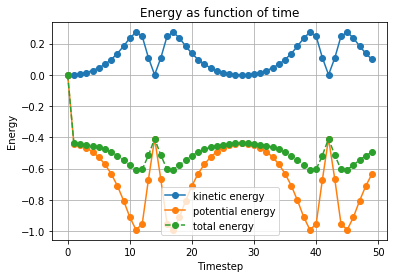

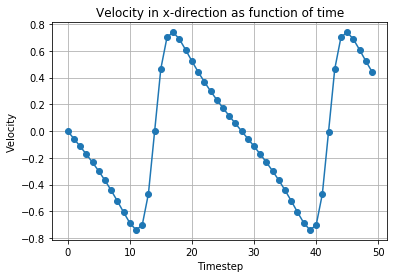

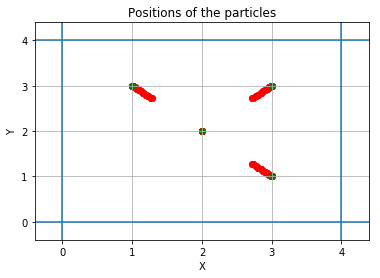

In [10]:
# plot the potential, kinetic and total energy
plt.title('Energy as function of time')
plt.plot(range(num_time), E_kin[1, :, 0], linestyle='-', marker='o', label='kinetic energy')
plt.plot(range(num_time), E_pot[1, :], linestyle='-', marker='o', label='potential energy')    
plt.plot(range(num_time), E_tot[1, :], linestyle='--', marker='o', label='total energy')
plt.xlabel('Timestep')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.figure()

# plot the velocity in x-direction
plt.title('Velocity in x-direction as function of time')
plt.plot(range(num_time), state[1, :, 3], linestyle='-', marker='o', label='velocity')
plt.xlabel('Timestep')
plt.ylabel('Velocity')
plt.grid()

# plot the positions of all particles in a new figure and plot the initial positions in green
plt.figure()
plt.title('Positions of the particles')
for x in range(num_part):
    plt.scatter(state[x, 1:, 0], state[x, 1:, 1], c='r', label='particle {}'.format(x))
    plt.scatter(state[x, 0, 0], state[x, 0, 1], c='g')

# restrict the view around the box + a small margin
view_margin = L / 10.0
plt.xlim(-view_margin, L + view_margin)
plt.ylim(-view_margin, L + view_margin)
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

# add border lines around the box
plt.axvline(0)
plt.axvline(L)
plt.axhline(0)
plt.axhline(L)

plt.show()

The simulation works (I think), because:
- The 3 particles move towards the particle in the center in the beginning
- At a certain point, the repulsive term dominates the attractive term, which causes the three particles to move away from the center again. This term is stonger and therefore has more effect on the velocities. At this point the sign of the velocity changes and there is a stronger potential energy. This causes the particles to oscillate around an equilibrium.
- The potential energy is always negative
- The total energy is conserved throughout time, but not during each oscillation. I don't know whether that should be the case.